In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

In [2]:
data = pd.read_csv('/Users/simonlipson/Downloads/aflstats/stats.csv')

In [3]:
data.head()

,Team,Player,D.O.B,Height,Weight,Position,Season,Round,Date,Score,...,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
0,Adelaide,"Atkins, Rory",1994-07-12,186,85,Midfield,2018,R1,2018-03-23,87.0,...,0,0,4,9,0,0,0,0,1,86
1,Adelaide,"Betts, Eddie",1986-11-26,174,74,Forward,2018,R1,2018-03-23,87.0,...,0,0,6,9,0,1,3,0,1,85
2,Adelaide,"Brown, Luke",1992-09-22,181,81,Defender,2018,R1,2018-03-23,87.0,...,0,0,1,10,0,0,2,0,0,82
3,Adelaide,"Crouch, Matt",1995-04-21,182,80,Midfield,2018,R1,2018-03-23,87.0,...,1,0,11,31,0,0,0,0,1,80
4,Adelaide,"Doedee, Tom",1997-03-01,188,88,Defender,2018,R1,2018-03-23,87.0,...,0,0,8,14,0,0,9,1,0,93


In [4]:
data['new_index'] = data['Season'].astype(str) + data['Player'] 

In [5]:
data.columns

Index(['Team', 'Player', 'D.O.B', 'Height', 'Weight', 'Position', 'Season',
       'Round', 'Date', 'Score', 'Margin', 'WinLoss', 'Opposition', 'Venue',
       'Disposals', 'Kicks', 'Marks', 'Handballs', 'Goals', 'Behinds',
       'Hitouts', 'Tackles', 'Rebound50s', 'Inside50s', 'Clearances',
       'Clangers', 'FreesFor', 'FreesAgainst', 'BrownlowVotes',
       'ContendedPossessions', 'UncontendedPossessions', 'ContestedMarks',
       'MarksInside50', 'OnePercenters', 'Bounces', 'GoalAssists',
       'PercentPlayed', 'new_index'],
      dtype='object')

In [6]:
features = data.groupby('new_index').agg(
brownlowvotes = pd.NamedAgg(column = 'BrownlowVotes', aggfunc = 'sum'),
disposals = pd.NamedAgg(column = 'Disposals', aggfunc = 'sum'),
kicks = pd.NamedAgg(column = 'Kicks', aggfunc = 'sum'),
marks = pd.NamedAgg(column = 'Marks', aggfunc = 'sum'),
handballs = pd.NamedAgg(column = 'Handballs', aggfunc = 'sum'),
hitouts = pd.NamedAgg(column = 'Hitouts', aggfunc = 'sum'),
goals = pd.NamedAgg(column = 'Goals', aggfunc = 'sum'),
behinds = pd.NamedAgg(column = 'Behinds', aggfunc = 'sum'),
tackles = pd.NamedAgg(column = 'Tackles', aggfunc = 'sum'),
rebound50s = pd.NamedAgg(column = 'Rebound50s', aggfunc = 'sum'),
inside50s = pd.NamedAgg(column = 'Inside50s', aggfunc = 'sum'),
clearances = pd.NamedAgg(column = 'Clearances', aggfunc = 'sum'),
clangers = pd.NamedAgg(column = 'Clangers', aggfunc = 'sum'),
freesfor = pd.NamedAgg(column = 'FreesFor', aggfunc = 'sum'),
freesagainst = pd.NamedAgg(column = 'FreesAgainst', aggfunc = 'sum'),
contendedpossessions = pd.NamedAgg(column = 'ContendedPossessions', aggfunc = 'sum'),
uncontendedpossessions = pd.NamedAgg(column = 'UncontendedPossessions', aggfunc = 'sum'),
contestedmarks = pd.NamedAgg(column = 'ContestedMarks', aggfunc = 'sum'),
marksinside50 = pd.NamedAgg(column = 'MarksInside50', aggfunc = 'sum'),
oncepercenters = pd.NamedAgg(column = 'OnePercenters', aggfunc = 'sum'),
bounces = pd.NamedAgg(column = 'Bounces', aggfunc = 'sum'),
goalassist = pd.NamedAgg(column = 'GoalAssists', aggfunc = 'sum'),
percentplayed = pd.NamedAgg(column = 'PercentPlayed', aggfunc = np.mean),
)

In [7]:
features.head()

,brownlowvotes,disposals,kicks,marks,handballs,hitouts,goals,behinds,tackles,rebound50s,...,freesfor,freesagainst,contendedpossessions,uncontendedpossessions,contestedmarks,marksinside50,oncepercenters,bounces,goalassist,percentplayed
new_index,,,,,,,,,,,,,,,,,,,,,
"2012Ablett, Gary",24,675,389,61,286,0,26,19,110,61,...,41,28,298,368,14,13,32,31,19,92.450000
"2012Adams, Leigh",4,344,180,50,164,1,17,15,59,12,...,16,15,134,196,2,8,32,0,15,75.166667
"2012Adams, Taylor",0,298,167,51,131,0,5,1,53,29,...,18,16,122,179,1,1,17,3,4,76.666667
"2012Adcock, Jed",0,404,244,104,160,0,3,2,85,81,...,25,15,111,274,5,2,65,1,11,88.714286
"2012Addison, Dylan",0,232,129,81,103,0,7,5,40,25,...,11,16,83,156,14,7,51,3,0,90.000000


In [8]:
features.shape

(4651, 23)

In [9]:
def get_year_stats(x):

    return pd.read_html('https://afltables.com/afl/stats/{}.html'.format(x))

In [10]:
def combine_team_tables(df, year, clubs):
    
    frames = []
    for i in range(1,clubs):
        frames.append(df[i].iloc[:-1])
    
    for i in range(len(frames)): 
        frames[i].columns = frames[i].columns.get_level_values(1)
        
    df = pd.concat(frames, axis=0, ignore_index = True)
    
    df['Season'] = year
    
    df['new_index'] = df['Season'] + df['Player']
    
    return df

In [11]:
def normalize_columns(df):

    return df.rename(columns={'BR': 'BrownlowVotes',
                                     'DI': 'Disposals',
                                     'KI': 'Kicks',
                                     'MK': 'Marks',
                                     'HB': 'Handballs',
                                     'HO': 'Hitouts',
                                     'GL': 'Goals',
                                     'BH': 'Behinds',
                                     'TK': 'Tackles',
                                     'RB': 'Rebound50s',
                                     'IF': 'Inside50s',
                                     'CL': 'Clearances',
                                     'CG': 'Clangers',
                                     'FF': 'FreesFor',
                                     'FA': 'FreesAgainst',
                                     'CP': 'ContendedPossessions',
                                     'UP': 'UncontendedPossessions',
                                     'CM': 'ContestedMarks',
                                     'MI': 'MarksInside50',
                                     '1%': 'OnePercenters',
                                     'BO': 'Bounces',
                                     'GA': 'GoalAssists',
                                     '%P': 'PercentPlayed'}, inplace=True)

In [12]:
def engineer_features(df):

    return df.groupby('new_index').agg(
    brownlowvotes = pd.NamedAgg(column = 'BrownlowVotes', aggfunc = 'sum'),
    disposals = pd.NamedAgg(column = 'Disposals', aggfunc = 'sum'),
    kicks = pd.NamedAgg(column = 'Kicks', aggfunc = 'sum'),
    marks = pd.NamedAgg(column = 'Marks', aggfunc = 'sum'),
    handballs = pd.NamedAgg(column = 'Handballs', aggfunc = 'sum'),
    hitouts = pd.NamedAgg(column = 'Hitouts', aggfunc = 'sum'),
    goals = pd.NamedAgg(column = 'Goals', aggfunc = 'sum'),
    behinds = pd.NamedAgg(column = 'Behinds', aggfunc = 'sum'),
    tackles = pd.NamedAgg(column = 'Tackles', aggfunc = 'sum'),
    rebound50s = pd.NamedAgg(column = 'Rebound50s', aggfunc = 'sum'),
    inside50s = pd.NamedAgg(column = 'Inside50s', aggfunc = 'sum'),
    clearances = pd.NamedAgg(column = 'Clearances', aggfunc = 'sum'),
    clangers = pd.NamedAgg(column = 'Clangers', aggfunc = 'sum'),
    freesfor = pd.NamedAgg(column = 'FreesFor', aggfunc = 'sum'),
    freesagainst = pd.NamedAgg(column = 'FreesAgainst', aggfunc = 'sum'),
    contendedpossessions = pd.NamedAgg(column = 'ContendedPossessions', aggfunc = 'sum'),
    uncontendedpossessions = pd.NamedAgg(column = 'UncontendedPossessions', aggfunc = 'sum'),
    contestedmarks = pd.NamedAgg(column = 'ContestedMarks', aggfunc = 'sum'),
    marksinside50 = pd.NamedAgg(column = 'MarksInside50', aggfunc = 'sum'),
    oncepercenters = pd.NamedAgg(column = 'OnePercenters', aggfunc = 'sum'),
    bounces = pd.NamedAgg(column = 'Bounces', aggfunc = 'sum'),
    goalassist = pd.NamedAgg(column = 'GoalAssists', aggfunc = 'sum'),
    percentplayed = pd.NamedAgg(column = 'PercentPlayed', aggfunc = np.mean),
    )

In [13]:
def feature_engineering_pipeline(year, clubs):
    
    df = combine_team_tables(get_year_stats(year), year, clubs)
    normalize_columns(df)
    return engineer_features(df)

In [14]:
missing_years_16_clubs = [str(i) for i in range(2003,2011)]
missing_2011 = '2011'
missing_2019 = '2019'

In [15]:
new_data = []
for year in missing_years_16_clubs:
    globals()['data_' + year] = feature_engineering_pipeline(year, 17)
    new_data.append(globals()['data_' + year])

In [16]:
data_2011 = feature_engineering_pipeline('2011', 18)
data_2019 = feature_engineering_pipeline('2019', 19)

new_data.append(data_2011)
new_data.append(data_2019)
new_data.append(features)


In [17]:
all_data_2003_2019 = pd.concat(new_data, axis=0, ignore_index = False)

all_data_2003_2019

,brownlowvotes,disposals,kicks,marks,handballs,hitouts,goals,behinds,tackles,rebound50s,...,freesfor,freesagainst,contendedpossessions,uncontendedpossessions,contestedmarks,marksinside50,oncepercenters,bounces,goalassist,percentplayed
new_index,,,,,,,,,,,,,,,,,,,,,
"2003Ablett, Gary",3.0,327.0,189.0,61.0,138.0,0.0,26.0,20.0,77.0,14.0,...,21.0,11.0,185.0,163.0,6.0,11.0,42.0,30.0,11.0,93.700000
"2003Ablett, Luke",0.0,17.0,10.0,6.0,7.0,0.0,1.0,0.0,0.0,3.0,...,0.0,1.0,7.0,11.0,1.0,1.0,2.0,0.0,0.0,29.500000
"2003Adkins, Damien",0.0,59.0,46.0,16.0,13.0,0.0,7.0,6.0,8.0,1.0,...,2.0,3.0,18.0,42.0,2.0,4.0,6.0,1.0,1.0,49.800000
"2003Akermanis, Jason",5.0,452.0,350.0,99.0,102.0,0.0,28.0,32.0,84.0,32.0,...,13.0,23.0,173.0,260.0,6.0,18.0,28.0,40.0,19.0,88.500000
"2003Alessio, Steven",0.0,138.0,90.0,43.0,48.0,170.0,9.0,6.0,12.0,11.0,...,9.0,17.0,79.0,57.0,7.0,12.0,15.0,0.0,4.0,57.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"2018Ziebell, Jack",7.0,376.0,267.0,104.0,109.0,0.0,35.0,29.0,77.0,21.0,...,27.0,28.0,179.0,201.0,23.0,34.0,38.0,2.0,13.0,88.454545
"2018Zorko, Dayne",6.0,457.0,302.0,54.0,155.0,0.0,26.0,18.0,159.0,29.0,...,43.0,37.0,215.0,242.0,2.0,8.0,21.0,8.0,14.0,83.818182
"2018Zurhaar, Cameron",0.0,52.0,30.0,5.0,22.0,1.0,2.0,5.0,14.0,2.0,...,3.0,5.0,24.0,28.0,0.0,1.0,5.0,1.0,2.0,71.000000


In [18]:
all_data_2003_2019.isnull().sum()

brownlowvotes             0
disposals                 0
kicks                     0
marks                     0
handballs                 0
hitouts                   0
goals                     0
behinds                   0
tackles                   0
rebound50s                0
inside50s                 0
clearances                0
clangers                  0
freesfor                  0
freesagainst              0
contendedpossessions      0
uncontendedpossessions    0
contestedmarks            0
marksinside50             0
oncepercenters            0
bounces                   0
goalassist                0
percentplayed             0
dtype: int64

In [19]:
years = ['2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

In [20]:
X_train = []

for index, year in enumerate(years):
    
    train_years = years[:index] + years[index+1 :]

    X_train.append(all_data_2003_2019.filter(regex='|'.join(train_years), axis=0).iloc[:,1:23])

In [21]:
y_train = []

for index, year in enumerate(years):
    
    train_years = years[:index] + years[index+1 :]

    y_train.append(all_data_2003_2019.filter(regex='|'.join(train_years), axis=0).iloc[:,0])

In [22]:
X_test = []

for year in years:

    X_test.append(all_data_2003_2019.filter(regex=year, axis=0).iloc[:,1:23])

In [23]:
y_test = []

for year in years:
    
    y_test.append(all_data_2003_2019.filter(regex=year, axis=0).iloc[:,0])

In [24]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('GBM', GradientBoostingRegressor()))


results = []
names = []
print('Model r2 results:')
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train[0], y_train[0], cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Model r2 results:
LR: 0.620313 (0.026919)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


LASSO: 0.609004 (0.025734)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


EN: 0.616914 (0.026293)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


KNN: 0.663504 (0.025216)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


CART: 0.423164 (0.036622)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


GBM: 0.710297 (0.029830)


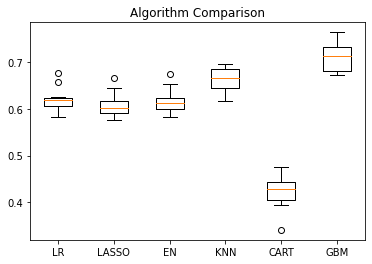

In [25]:
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [26]:
model = LinearRegression()
results = []
for i in range(len(X_test)):
    model.fit(X_train[i], y_train[i])
    y_pred = model.predict(X_test[i])
    results.append(pd.DataFrame({'actual': y_test[i],
                                'prediction': y_pred})
                  .sort_values('prediction', ascending=False).reset_index())

In [27]:
joined_results = pd.concat(results, axis = 1)

In [28]:
joined_results['new_index'].head()

,new_index,new_index,new_index,new_index,new_index,new_index,new_index,new_index,new_index,new_index,new_index,new_index,new_index,new_index,new_index,new_index,new_index
0,"2003Buckley, Nathan","2004Judd, Chris","2005Judd, Chris","2006Judd, Chris","2007Ablett, Gary","2008Mitchell, Sam","2009Ablett, Gary","2010Ablett, Gary","2011Kennedy, Josh","2012Kennedy, Josh P","2013Kennedy, Josh P","2014Gray, Robbie","2015Fyfe, Nat","2016Dangerfield, Patrick","2017Martin, Dustin","2018Mitchell, Tom","2019Neale, Lachie"
1,"2003Cousins, Ben","2004Brown, Nathan","2005Cousins, Ben","2006Goodwin, Simon","2007Burgoyne, Shaun","2008Ablett, Gary","2009Boyd, Matthew","2010Swan, Dane","2011Swan, Dane","2012Dangerfield, Patrick","2013Liberatore, Tom","2014Selwood, Joel","2015Dangerfield, Patrick","2016Kennedy, Josh P","2017Dangerfield, Patrick","2018Ward, Callan","2019Fyfe, Nat"
2,"2003Simpson, Adam","2004Black, Simon","2005Hodge, Luke","2006Mitchell, Sam","2007Corey, Joel","2008Cooney, Adam","2009Judd, Chris","2010Boyd, Matthew","2011Boyd, Matthew","2012Ablett, Gary","2013Ablett, Gary","2014Dangerfield, Patrick","2015Gray, Robbie","2016Selwood, Joel","2017Ward, Callan","2018Martin, Dustin","2019Cunnington, Ben"
3,"2003Ricciuto, Mark","2004Simpson, Adam","2005Koutoufides, Anthony","2006West, Scott","2007Simpson, Adam","2008Judd, Chris","2009Dal Santo, Nick","2010Judd, Chris","2011Thompson, Scott","2012Swan, Dane","2013Fyfe, Nat","2014Jones, Nathan","2015Cunnington, Ben","2016Neale, Lachie","2017Shiel, Dylan","2018Cripps, Patrick","2019Cripps, Patrick"
4,"2003Black, Simon","2004Ricciuto, Mark","2005Kirk, Brett","2006Cousins, Ben","2007Kerr, Daniel","2008Franklin, Lance","2009Mitchell, Sam","2010Montagna, Leigh","2011Murphy, Marc","2012Watson, Jobe","2013Pendlebury, Scott","2014Fyfe, Nat","2015Kennedy, Josh P","2016Parker, Luke","2017Crouch, Matt","2018Neale, Lachie","2019Dangerfield, Patrick"
